In [41]:
import numpy as np
import torch
from torchvision.datasets import mnist#导入pytorch内置的mnist数据
#导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
#导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn


#定义一些超参数
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 5
lr = 0.01
momentum = 0.5

下载数据并预处理

In [42]:
#定义预处理函数，这些预处理依次放在Compose函数中。
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])#transforms.Compose可以把一些转换函数组合在一起
#Normalize([0.5], [0.5])对张量进行归一化，这里两个0.5分别表示对张量进行归一化的全局平均值和方差。因图像是灰色的只有一个通道，如果有多个通道，需要有多个数字，如三个通道，应该是Normalize([m1,m2,m3], [n1,n2,n3])
train_dataset = mnist.MNIST('../data', train=True, transform=transform, download=True)
test_dataset = mnist.MNIST('../data', train=False, transform=transform)
#dataloader是一个可迭代对象，可以使用迭代器一样使用
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle = False)

可视化源数据

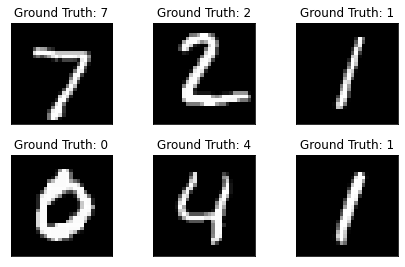

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline


examples = enumerate(test_loader)#enumerate() 函数用于将一个可遍历的数据对象组合为一个索引序列，同时列出数据和数据下标
batch_idx, (example_data, example_targets) = next(examples)#next() 返回迭代器的下一个项目

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

构建网络

In [44]:
class Net(nn.Module):
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x
    

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net(784, 300, 100, 10)
model.to(device)

#定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

训练模型

In [45]:
#开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []

for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    #动态修改参数学习率
    if epoch%5==0:
        optimizer.param_groups[0]['lr']*=0.1
    for img, label in train_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        #前向传播
        out = model(img)
        loss = criterion(out, label)
        #反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #记录误差
        train_loss += loss.item()
        #计算分类的准确率
        _,pred = out.max(1)
        num_correct =(pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc
    
    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    #在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    #将模型改为预测模式
    model.eval()
    for img, label in test_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        out = model(img)
        loss = criterion(out, label)
        #记录误差
        eval_loss += loss.item()
        #记录准确率
        _,pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc
        
    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    print('epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'
          .format(epoch, train_loss / len(train_loader), train_acc / len(train_loader), 
                     eval_loss / len(test_loader), eval_acc / len(test_loader)))

epoch: 0, Train Loss: 1.0376, Train Acc: 0.7784, Test Loss: 0.5516, Test Acc: 0.8991
epoch: 1, Train Loss: 0.4858, Train Acc: 0.8974, Test Loss: 0.3567, Test Acc: 0.9249
epoch: 2, Train Loss: 0.3518, Train Acc: 0.9180, Test Loss: 0.2774, Test Acc: 0.9375
epoch: 3, Train Loss: 0.2874, Train Acc: 0.9309, Test Loss: 0.2319, Test Acc: 0.9444
epoch: 4, Train Loss: 0.2436, Train Acc: 0.9395, Test Loss: 0.2000, Test Acc: 0.9511


In [ ]:
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)
plt.legend(['Train Loss'], loc='upper right')

In [52]:
torch.save(model.state_dict(),"fc_trained_model.pth")

In [53]:
import torch
import os
from PIL import Image
from torch.utils.data import Dataset


class MyMnistDataset(Dataset):
    def __init__(self, root, transform):

        self.myMnistPath = root
        self.imagesData = []
        self.labelsData = []
        self.labelsDict = {}
        self.trans = transform

        self.loadLabelsDate()
        self.loadImageData()

    # 读取标签txt文件，并生成字典
    def loadLabelsDate(self):
        labelsPath = os.path.join(self.myMnistPath, "labels", "labels.txt")
        f = open(labelsPath)
        lines = f.readlines()
        for line in lines:
            name = line.split(' ')[0]
            label = line.split(' ')[1]
            self.labelsDict[name] = int(label)

    # 读取手写图片数据，并将图片数据和对应的标签组合在一起
    def loadImageData(self):
        imagesFolderPath = os.path.join(self.myMnistPath, 'images')
        imageFiles = os.listdir(imagesFolderPath)

        for imageName in imageFiles:
            imagePath = os.path.join(imagesFolderPath, imageName)
            image = Image.open(imagePath)
            grayImage = image.convert("L")

            imageTensor = self.trans(grayImage)
            self.imagesData.append(imageTensor)

            self.labelsData.append(self.labelsDict[imageName])

        self.labelsData = torch.Tensor(self.labelsData)

    # 重写魔法函数
    def __getitem__(self, index):
        return self.imagesData[index], self.labelsData[index]

    # 重写魔法函数
    def __len__(self):
        return len(self.labelsData)






transform = transforms.Compose([
    transforms.Resize([28, 28]),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 载入自己的数据集
dataset = MyMnistDataset(root='../data/my_mnist_dateset', transform=transform)
test_loader = DataLoader(dataset=dataset, shuffle=False)

# 生成全连接神经网络并载入训练好的模型
model = Net(784, 300, 100, 10)
model.load_state_dict(torch.load("./fc_trained_model.pth"))


def test():
    correct = 0
    total = 0
    print("label       predicted")
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            print("{}          {}".format(int(labels.item()), predicted.data.item()))

        print('FC trained model: accuracy on mymnist set:%d %%' % (100 * correct / total))


if __name__ == '__main__':
    test()

label       predicted


RuntimeError: mat1 and mat2 shapes cannot be multiplied (28x28 and 784x300)